# The StatQuest Illustrated Guide to Neural Networks and AI
## Chapter 14 - Encoder-Only Transformers!!!

## **Summarizing Documents with Text Clustering and Topic Modeling**

----

This tutorial is from the book, **[The StatQuest Illustrated Guide to Neural Networks and AI](https://www.amazon.com/dp/B0DRS71QVQ)**.

**NOTE:** This notebook is heavily based on the tutorial in Chapter 5 of *[Hands-On Large Language Models](https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/)* by [Jay Alammar](https://www.linkedin.com/in/jalammar/) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/). This book is amazing, and I highly recommend purchasing it ASAP. Anyway, I changed a few things from their original code and descriptions, mainly by adding to what they already did.

The idea here (illustrated below) is that we start with a bunch of documents about all kinds of things, and we want to cluster the documents and give each cluster a title. We'll use an Encoder-Only LLM, or Representative AI, to cluster the documents based on similar themes, topics, and meanings rather than just keywords or neighboring words (like we did with Word Embedding). Then, we'll use a Decoder-Only LLM, or Generative AI, to give each cluster an excellent title. And we'll do all of this without knowing anything about these documents in advance. So, this gives us a great tool for exploratory data analysis and dealing with vast archives that we otherwise would need help with.

<img src="images/text_summarization_overview.png" alt="the curse of high dimensionality" width="800" />


---
        
**NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

# Install packages

In [3]:
%%capture 
## NOTE: Installation might take a couple of minutes, so go get yourself a snack!
## %%capture prevents this cell from printing a ton of STDERR stuff to the screen

!pip install bertopic datasets datamapplot WordCloud
## bertopic - BERTopic is a BERT based LLM that combines transformers and c-TF-IDF 
##            to create clusters of easily interpretable topics
##            NOTE: By default, bertopic comes with sentence-transformers (aka SBERT), UMAP and HDBSCAN
##                  because those, plus C-TF-IDF, form the standard BERTopic pipeline.
## datasets - a huggingface package that makes it easy to access datasets stored on their site
## datamapplot - creates nice looking plots of data maps
## WordCloud - generates word clouds

**NOTE**: Make sure to **restart** the runtime after installing the above packages!

---

# Load the data

In this tutorial, we will use a [subset](https://huggingface.co/datasets/MaartenGr/arxiv_nlp) of the [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv) that was created by [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/) specifically for the *[Hands-On Large Language Models](https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/)* book. The dataset contains 44,949 abstracts published between 1991 and 2024 from ArXiv’s Computation and Language section, aka cs.CL.

In [4]:
# Load the data directly from huggingface using their datasets module
from datasets import load_dataset

dataset = load_dataset("maartengr/arxiv_nlp")["train"]
dataset

ModuleNotFoundError: No module named 'datasets'

Now, pull out the abstracts and the titles...

In [3]:
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

...and then print out the first 2 abstracts.

In [4]:
abstracts[0:2]

['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
 '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic mo

---

# **Part 1: Text Clustering**

There are many methods for text clustering, but the one we'll use in this tutorial has
three steps:

1. Convert the input documents to embeddings with an *embedding model*.
    In this example, we'll use [SBERT](https://www.sbert.net/), also knowing as SentenceTransformers, to create the embeddings. SBERT is an Encoder-Only Transformer, which is a type of Representative AI.
2. Reduce the dimensionality of embeddings with a *dimensionality reduction model*. In this example,
   we'll use UMAP to reduce the dimensions of the model. To learn more about UMAP, see this [StatQuest](https://youtu.be/eN0wFzBA4Sc).
3. Find groups of semantically similar documents with a *cluster model*. In this example, we'll use HDBSCAN, which is a hierarchical version of DBSCAN. To learn more about DBSCAN, check out the [StatQuest](https://youtu.be/RDZUdRSDOok) and [this great description of HDBSCAN specifics.](https://pberba.github.io/stats/2020/01/17/hdbscan/)

We'll start by converting the abstracts into embeddings.

## **Part 1, Step 1: Convert the abstracts into embeddings**

The pre-trained SBERT model that we'll use to convert the abstracts into embeddings is the [gte-small model](https://huggingface.co/thenlper/gte-small) - the "gte" part stands for "General Text Embeddings," and the "small" refers to its relative size; it only has 33 million parameters, whereas many other models have well over 100 million parameters (to see for yourself, you can compare models on HuggingFace's [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard). **NOTE:** The gte-small model only accepts 512 tokens and any input that is longer than that is truncated.

In [5]:
from sentence_transformers import SentenceTransformer

# download the pre-trained SBERT model
embedding_model = SentenceTransformer('thenlper/gte-small')

## create the embeddings for the abstracts.
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches: 100%|██████████| 1405/1405 [02:20<00:00, 10.03it/s]


Now that we've created the embeddings, we can verify that all 44,949 abstracts have 384 word embedding values associated with them by printing out the `.shape`.

In [6]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## **Part 1, Step 2: Reduce the Dimensionality of Embeddings**

The model we used to create the embeddings, gte-small, is a general-purpose model designed to perform well given a wide variety of tasks, like classification and ranking, and, as a result, creates more embedding values than we need for clustering. Having too many embedding values, or dimensions, results in sparse data that can be difficult to cluster and is an example of [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The illustration below shows the curse in action. On the left, we have 3 data points in a 2-dimensional graph. Each point is relatively far from the others, and thus, it's difficult to know how to best cluster them. However, in the center, we reduced the dimension to just the y-axis and, on the right side, we we see points A and B are relatively close to each other compared to point C. Thus, we'll put points A and B together in a cluster.

<img src="images/curse_of_high_d.png" alt="the curse of high dimensionality" width="800" />

One popular method for reducing dimensions is UMAP, which stands for Uniform Manifold Approximation and Projection, and we'll use it to reduce the dimensions from 384 to 5. **NOTE:** The distance metric that we are using is the Cosine Similarity. If you are not already familiar with the Cosine Similarity, check out the [StatQuest](https://youtu.be/e9U0QAFbfLI).

In [7]:
#from umap import UMAP
import umap.umap_ as UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP.UMAP(
    n_components=5, 
    min_dist=0.0, 
    metric='cosine', 
    random_state=42
)
reduced_embeddings_5 = umap_model.fit_transform(embeddings)

/home/evlossio/myprojects/signa/StatQuest/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/evlossio/myprojects/signa/StatQuest/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
# Check the dimensions of the reduced embeddings
reduced_embeddings_5.shape

(44949, 5)

## **Part 1, Step 3: Cluster the Reduced Embeddings**

Now that we have reduced the number of dimensions (or values) of our embeddings from 384 to just 5, we can try to find clusters. In this example, we'll use HDBSCAN to find the clusters.

In [10]:
#from hdbscan import HDBSCAN
from sklearn.cluster import HDBSCAN
## NOTE: The HDBSCAN call will generate a bunch of warnings. 
## If those bother you, you can run this code:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Find and label clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, # each cluster must have >= 50 documents in it
    metric='euclidean',  # clustering is based on euclidean distance
    cluster_selection_method='eom' # eom = Excess of Mass and is the default clustering selection method
).fit(reduced_embeddings_5)
clusters = hdbscan_model.labels_

In [11]:
# Print out the number of cluseters
len(set(clusters)) # set() removes duplicates - so we only count the unique cluster labels

162

Now that we have created the clusters, we can examine the first one to see if it makes sense. We do this by printing out the first three abstracts in the first cluster.

In [12]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



### Draw a 2-d graph of the clusters

Drawing a graph to visualize the clusters takes two steps. First, we reduce the original 384 embeddings to two dimensions so that we can visualize them and get a rough understanding of the generated clusters.

In [14]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings_2 = UMAP.UMAP(
    n_components=2, 
    min_dist=0.0, 
    metric='cosine', 
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings_2, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/home/evlossio/myprojects/signa/StatQuest/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/evlossio/myprojects/signa/StatQuest/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Now that we have 2-dimensional data, we can do the second step: plot it.

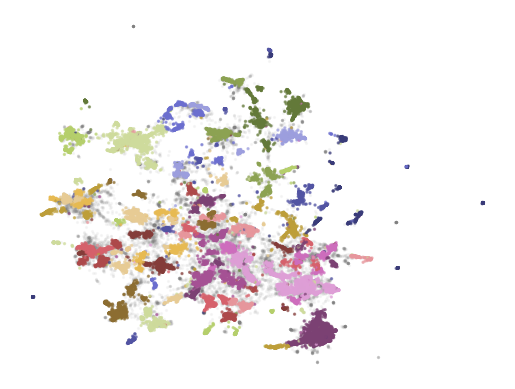

In [16]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png
plt.show()

**BAM!** 
We've got a graph that shows how the 44,949 abstracts cluster. It's a bit messy, and because we have so many clusters, the colors are reused for different clusters (this means the light green patch at the top is a distinct cluster from the light green patch close to the middle). However, it's still cool.

Now we're done with the **Text Clustering** part of this tutorial. The next step, **Topic Modeling**, gives each cluster an easy to understand label based on the overall theme that each cluster represents.

---

# **Part 2: Topic Modeling**

To generate labels for each cluster, we'll first generate keywords and then feed those keywords into a generative LLM to create the labels. We'll use **BERTopic** to coordinate both steps.

## **Part 2, Step 1: Generate keywords**

We'll start by using **BERTopic** to do what we did in Part 1 (Text Clustering by first creating word embeddings, then reducing the dimensions of the embeddings, and then clustering). However, because we are using BERTopic this time, it will also extract keywords representing each cluster.
The keywords are determined with a class-based variant of Term Frequency Inverse Document Frequency **c-TF-IDF**.

To get **BERTopic** going, we pass it the embedding, UMAP, and DBSCAN models we created earlier, and fit it to the abstracts using the embeddings we created earlier.

In [ ]:
topic_model.get_topic_info()

To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function. For example, for the first non-outlier topic...

In [ ]:
topic_model.get_topic(0)

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [ ]:
topic_model.find_topics("topic modeling")

We can also see if the BERTopic paper was also assigned to topic the same topic:

In [ ]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

It is! **BAM!**

Now that we have keywords for each topic, we can use BERTopic to create a new, interactive 2-D graph of the text clusters that includes the topic labels and shows manuscript titles when the mouse moves over the points.

In [ ]:
## Visualize topics and documents
## NOTE: THIS WORKS ON GOOGLE COLAB BUT NOT ON RUNPOD...
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings_2,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

## **Part 2, Step 2: Using Generative AI to create topic labels**

Now that we have the keywords, we'll add a Decoder-Only LLM, or Generative AI, to the **BERTopic** framework to create labels. However, 
first, we will duplicate our original topic model to easily compare the original keywords with the new labels.

In [ ]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

We'll also create a helper function `compare_topics` that shows the original and the new topics.

In [ ]:
def topics_vs_labels(original_topics, model, nr_topics=5):
    """Show the differences in topics and the new labels"""
    df = pd.DataFrame(columns=["Topic ID", "Original Topics", "New Labels"])
    for topic in range(nr_topics):

        # Extract top 5 words from the original topic
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = model.get_topic(topic)[0][0]
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

Now that we have the helper function, we'll generate labels from the keywords and abstracts using the **flan-t5-small** Decoder-Only LLM for Generative AI.

In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small', device=0)
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

Now, let's compare the original keywords to the new labels...

In [ ]:
# compare the original topics with the new labels
topics_vs_labels(original_topics, topic_model)

Now, it's probably subjective, but to me, the new labels do a good job capturing the essence of the keywords. So I say **BAM!**

### **Draw an awesome 2-D graph of the documents with the new labels**

Now that we have labels for each cluster, let's draw a very cool looking graph that shows the document clusters with the new labels. This still uses the **BERTopic** framework that we've been working with, which uses the `datamapplot` module to draw the graph.

In [ ]:
# Visualize documents with labeled topics
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings_2,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)

What a cool looking graph! And its got awesome easy to understand labels!!

# **TRIPLE BAM!!!** 


## **BONUS**: WordCloud



First, we need to ensure that each topic is described by a bit more words than just 10, as that would make for a much more interesting WordCloud.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)

Then, we can run the following code to generate the WordCloud for our topic modeling topic:

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)